# Signal convolutions

Time invariant filter in the previous notebook assumes that the filter coefficients are stored as the weight of the 1D convolution layer. However, when we wish to predict the filter coefficients from another network, we need to use a different API that receives the filter coefficients as input rather than Module.parameter. This motivates the signal convolution wrapper.

![Images_c6_1](./figures/fig_c6_1.png)


We define a wrapper over torch.nn.functional.conv1d with the following behaviors:

1. Input 1 is a tensor of shape (batchsize, length, dim)
2. Input 2 is a tensor of shape (length_2, dim), which is assumed as the time invarint filter coefficients
3. Output tensor has shape (batchsize, length, dim)
4. Convolution is conducted for each dimension separately.

(I apologize that the tensor of Input 2 is (length_2, dim) rather than (batchsize=1, length_2, dim). I will consider change the wrapper definition in near future)



### 1. Module definition

Operations defined in this signal modulation wrapper are illustrated below. 

Note that each dimension of input signal is processed by a different filter.

![Images_c6_2](./figures/fig_c6_2.png)

In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class SignalsConv1d(torch_nn.Module):
    """ Filtering input signal with time invariant filter
    
    Define: 
        SignalsConv1d()
    See usage in forward() method
    """                                                                   
    def __init__(self):
        super(SignalsConv1d, self).__init__()
        
    def forward(self, signal, system_ir):
        """ output = forward(signal, system_ir)
        
        signal:    (batchsize, length1, dim)
        system_ir: (length2, dim) 
        
        output:    (batchsize, length1, dim)
        
        Note: 
        """ 
        if signal.shape[-1] != system_ir.shape[-1]:
            print("Error: TimeInvariantFiltering expects shape:")
            print("signal    (batchsize, length1, dim)")
            print("system_id (batchsize, length2, dim)")
            sys.exit(1)
            
        # similar opration to Conv1dInvFilter
        # system_ir.shape[0] -> kernel_size
        # padding length
        padding_length = system_ir.shape[0] - 1
        
        # groups = signal.shape[-1] so that convoluion is separately 
        #  for each dimension
        groups = signal.shape[-1]
        
        # 1. siwtch dimension of the signal from (batch, length, dim) to (batch, dim, length)
        # 2. pad signal on the left to (batch, dim, length + pad_length)
        signal_pad = torch_nn_func.pad(signal.permute(0, 2, 1),\
                                       (padding_length, 0))
        
        # 1. add one dimension to system_ir and makes its shape (length2, 1, dim)
        # 2. switch dimension and prepare system_id as (dim, 1, length2)
        # 3. flip the impulse response 
        ir = torch.flip(system_ir.unsqueeze(1).permute(2, 1, 0), \
                        dims=[2])
        
        # convolute
        output = torch_nn_func.conv1d(signal_pad, ir, \
                                      groups=groups)
        # switch dimension from (batch, dim, length) to (batch, length, dim)
        return output.permute(0, 2, 1)

### 2. Simple example


(<Figure size 108x72 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7fee43867990>])

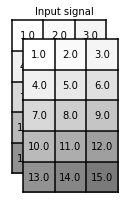

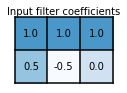

In [2]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# input signal
data = torch.zeros([2, 5, 3])
data[0] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])
data[1] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])
signal_input = data

# 3 filters of order 2
filter_coefs_ir = torch.ones(2, 3)
filter_coefs_ir[1:, 0] = 0.5
filter_coefs_ir[1:, 1] = -0.5
filter_coefs_ir[1:, 2] = 0
# filter order (or kernel size)
filter_kernel_size = filter_coefs_ir.shape[0]

import plot_lib
plot_lib.plot_tensor(signal_input, color_on_value=True, title='Input signal')
plot_lib.plot_tensor(filter_coefs_ir.unsqueeze(0), color_on_value=True, colormap="Blues", title='Input filter coefficients')


(<Figure size 115.2x187.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fee439c2490>])

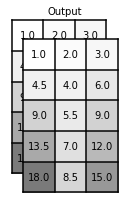

In [3]:
# do filtering
l_signal_convolution = SignalsConv1d()
signal_output = l_signal_convolution(signal_input, filter_coefs_ir)

plot_lib.plot_tensor(signal_output, color_on_value=True, title='Output')

We now show the operations in the wrapper step by step.

(<Figure size 115.2x187.2 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fee440df3d0>])

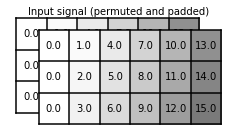

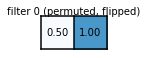

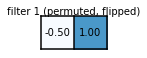

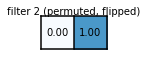

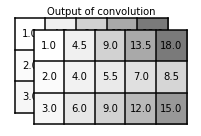

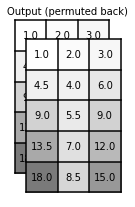

In [4]:
# step1. permute and pad the input signal tensor
padding_length = filter_kernel_size - 1
signal_pad = torch_nn_func.pad(signal_input.permute(0, 2, 1),(padding_length, 0))
plot_lib.plot_tensor(signal_pad, color_on_value=True, title='Input signal (permuted and padded)')

# step2. flip and store the input filter coefficients
filter_coefs_ir_flipped = torch.flip(filter_coefs_ir.unsqueeze(1).permute(2, 1, 0), dims=[2])
for feat_map_idx in range(filter_coefs_ir_flipped.shape[0]):
    plot_lib.plot_tensor(filter_coefs_ir_flipped[feat_map_idx:feat_map_idx+1], color_on_value=True, 
                         colormap="Blues", alpha=1.0,
                         title = 'filter %d (permuted, flipped)' % (feat_map_idx), deci_width=2)  
#plot_lib.plot_tensor(filter_coefs_ir_flipped, color_on_value=True, title='')

# step3. signal convolution using conv1d API
output = torch_nn_func.conv1d(signal_pad, filter_coefs_ir_flipped, groups=signal_input.shape[-1])
plot_lib.plot_tensor(output, color_on_value=True, title='Output of convolution')

# step4. permute back
plot_lib.plot_tensor(output.permute(0, 2, 1), color_on_value=True, title='Output (permuted back)')

### 3. More complicated example

Here we can try a high-pass filter $H(z)=1 - 0.97z^{-1}$. 

This is known as the parameterization of lip radiation in speech production model.
It is also known as pre-emphasis in speech processing community https://labrosa.ee.columbia.edu/doc/HTKBook21/node52.html (Eq. 5.1).

In [5]:
# input signal
signal_input = torch.randn(1, 100, 1)

# impulse response of an identiy sytem [1, -0.97] -> A high-pass filter
system_ir = torch.ones(2, 1)
system_ir[1:, :] = -0.97

# do filtering
filter_layer = SignalsConv1d()
signal_output = filter_layer(signal_input, system_ir)

[Text(0, 0, '0.00'), Text(0, 0, '1.57'), Text(0, 0, '3.14')]

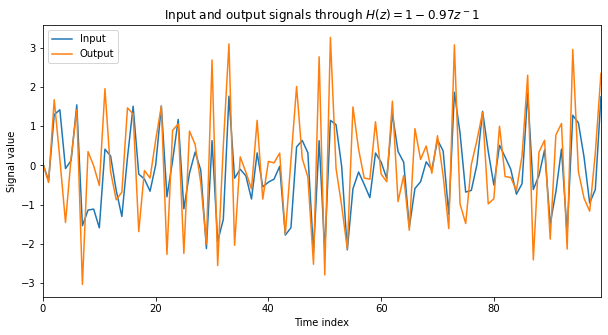

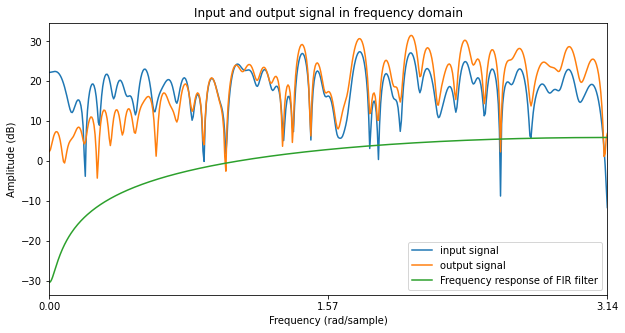

In [6]:
import plot_lib

# plot in time domain
fig = plt.figure()
axis = fig.add_subplot(111)
plot_lib.plot_signal(signal_input[0, :, 0], fig, axis)
plot_lib.plot_signal(signal_output[0, :, 0], fig, axis, 
                     xlabel='Time index', ylabel='Signal value', 
                     title='Input and output signals through $H(z) = 1 - 0.97 z^-1$')
axis.legend(['Input', 'Output'])

# plot in frequency domain
nfft = 1024
fig = plt.figure()
axis = fig.add_subplot(111)

h = scipy.fft.fft(signal_input[0, :, 0].detach().numpy(), n=nfft)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis)

h = scipy.fft.fft(signal_output[0, :, 0].detach().numpy(), n=nfft)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis)


w, h = scipy.signal.freqz(system_ir[:, 0], [1], worN=nfft, whole=True)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis, title='Input and output signal in frequency domain',
                    xlabel='Frequency (rad/sample)', ylabel='Amplitude (dB)')
axis.legend(['input signal', 'output signal', 'Frequency response of FIR filter'])
axis.set_xticks([0, nfft // 4, nfft // 2])
axis.set_xticklabels(['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])

The above example shows how the filter $H(z)=1 - 0.97z^{-1}$ emphasizes the energy of the high frequency components while suppresses the low frequency components.

### 4. Summary

Just repeat the definition, the signal convolution wrapper is defined over torch.nn.functional.conv1d with the following behaviors:
1. Input 1 is a tensor of shape (batchsize, length, dim)
2. Input 2 is a tensor of shape (length_2, dim), which is assumed as the time invariant filter coefficients
3. Output tensor has shape (batchsize, length, dim)
4. Convolution is conducted for each dimension in each batch separately.

This wrapper is used in cyclic-noise-NSF to convolute the exponentially decayed noise with pulse train.
